## **📄 Document type classification**


### 0. 라이브러리 임포트

In [2]:
%pip install timm albumentations pandas scikit-learn matplotlib seaborn -q


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
def count_files_in_folder(folder_path):
    return sum([len(files) for _, _, files in os.walk(folder_path)])

folder_path = "/workspace/test"
file_count = count_files_in_folder(folder_path)
print(f"총 파일 개수: {file_count}")

총 파일 개수: 3140


In [4]:
import os
import random
import shutil

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import AdamW
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

# 데이터 증강할 때 이미지 오버레이용
from albumentations.core.transforms_interface import ImageOnlyTransform

import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import csv
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## 3. Baseline Code

### 3.1 데이터 증강

In [14]:
train_dir = '/workspace/train'
test_dir = '/workspace/test'
train_csv_dir = '/workspace/train.csv'
sample_sub_dir = '/workspace/sample_submission.csv'

img_size = 224

In [4]:
# Augmentation- 이미지 겹치기
class RandomImageOverlay(A.ImageOnlyTransform):
    def __init__(self, overlay_dir, alpha=0.7, always_apply=False, p=0.4):
        super().__init__(always_apply=always_apply, p=p)
        self.overlay_dir = overlay_dir
        self.alpha = alpha
        self.overlay_images = [
            os.path.join(overlay_dir, img)
            for img in os.listdir(overlay_dir)
            if img.endswith(('.png', '.jpg', '.jpeg'))
        ]

    def apply(self, img, **params):
        overlay_path = random.choice(self.overlay_images)
        overlay = cv2.imread(overlay_path)
        overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

        # Resize overlay to match the size of the input image
        overlay = cv2.resize(overlay, (img.shape[1], img.shape[0]))

        # Blend the images
        blended_image = cv2.addWeighted(img, 1 - self.alpha, overlay, self.alpha, 0)
        return blended_image
    
# 오버레이 이미지 경로
overlay_dir = train_dir

In [5]:
# RGB 채널 mean, std 계산
def calculate_mean_std(image_dir):
    means = []
    stds = []
    image_count = 0

    for image_name in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)  # 이미지 읽기 (BGR 포맷)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB 포맷으로 변환
        img = img / 255.0  # 0~1 범위로 정규화

        means.append(np.mean(img, axis=(0, 1)))  # (H, W, C) -> R, G, B 채널별 평균
        stds.append(np.std(img, axis=(0, 1)))   # (H, W, C) -> R, G, B 채널별 표준편차

        image_count += 1

    # 전체 평균과 표준편차 계산
    mean = np.mean(means, axis=0)
    std = np.mean(stds, axis=0)

    return mean, std

mean, std = calculate_mean_std(train_dir)
mean = mean.tolist()
std = std.tolist()

# 결과 출력
print(f"RGB Mean: {mean}")
print(f"RGB Std: {std}")

RGB Mean: [0.5743355787358301, 0.5833040601054528, 0.5881892680045171]
RGB Std: [0.18964056010820535, 0.18694252072057732, 0.18506919246470202]


In [6]:
# 긴 변의 길이를 224로 맞춘 뒤 RGB 평균값 padding 추가
class ResizeImage(A.ImageOnlyTransform):
    def __init__(self, img_size=224, always_apply=False, p=1.0):
        super().__init__(always_apply=always_apply, p=p)
        self.img_size = img_size
        self.mean_color = (0, 0, 0)  # 초기화

    def apply(self, img, **params):
        # 이미지 크기 가져오기
        h, w = img.shape[:2]
        
        # 비율을 유지하며 긴 변을 img_size로 맞춤
        if h > w:
            new_h, new_w = self.img_size, int(w * (self.img_size / h))
        else:
            new_h, new_w = int(h * (self.img_size / w)), self.img_size
        
        resized_img = cv2.resize(img, (new_w, new_h))

        # 이미지의 평균 RGB 색상 계산 및 저장
        self.mean_color = tuple(map(int, resized_img.mean(axis=(0, 1))))

        # 패딩 계산
        delta_h = self.img_size - new_h
        delta_w = self.img_size - new_w
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        # 패딩 추가
        padded_img = cv2.copyMakeBorder(
            resized_img,
            top, bottom, left, right,  # 위, 아래, 왼쪽, 오른쪽 패딩
            cv2.BORDER_CONSTANT,
            value=self.mean_color  # 평균 RGB 패딩 색상
        )
        
        return padded_img

In [7]:
# 회전하고 생긴 부분 RGB 평균값으로 채우기
class RotateImage(A.ImageOnlyTransform):
    def __init__(self, limit=90, always_apply=False, p=1.0):
        super().__init__(always_apply=always_apply, p=p)
        self.limit = limit

    def apply(self, img, **params):
        # 이미지의 평균 RGB 값 계산
        mean_color = tuple(map(int, img.mean(axis=(0, 1))))

        # 회전 각도 설정
        angle = np.random.uniform(-self.limit, self.limit)

        # 이미지 중심 좌표 계산
        h, w = img.shape[:2]
        center = (w // 2, h // 2)

        # 회전 행렬 생성
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

        # 이미지 회전
        rotated_img = cv2.warpAffine(
            img,
            rotation_matrix,
            (w, h),
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=mean_color  # 계산된 평균 RGB 값으로 패딩
        )
        return rotated_img

In [8]:
# Train데이터 증강
trn_transform = A.Compose([
                        # 이미지 크기 조정
                        ResizeImage(img_size=img_size),
                        
                        # 색 조정
                        A.OneOf([
                                # A.Equalize(), # 명암대비 높이는 변환
                                A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3), # saturation: 채도 / Hue: 색조
                                A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30) # 색상 왜곡
                                # A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.4), # 색조, 채도, 밝기 이동 범위
                                ], p=0.4),

                        # 노이즈 추가
                        A.OneOf([
                                A.GaussNoise(var_limit=(10.0, 20.0), mean=0), # 랜덤한 픽셀값 추가해서 노이즈 줌
                                # A.ImageCompression(quality_lower=5, quality_upper=15, p=0.1), # 압축해서 이미지 품질을 저하시킴
                                ], p=0.3),

                        # 선명도 조정(선명 or 흐릿)
                        A.OneOf([
                                A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8)), # 선명(명암대비)
                                A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8)), # 선명(명암대비)
                                # A.Sharpen(alpha=(0.2, 0.4), lightness=(0.5, 1.0)), # 선명(엣지강조)
                                
                                A.GaussianBlur(blur_limit=(3, 3), sigma_limit=(0.1, 0.5)), # 흐릿
                                # A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.2, alpha_coef=0.08), # 흐릿. 안개 효과, alpha_coef: 안개의 투명도
                                A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.2, brightness_coeff=2), # 흐릿. 눈 효과, brightness_coeff: 눈의 밝기
                                A.RandomRain(slant_lower=-3, slant_upper=3, drop_length=2, drop_width=1, 
                                        drop_color=(200, 200, 200), blur_value=3, brightness_coefficient=0.7) # 흐릿. 비 효과, slant: 빗방울 기울기
                                ], p=0.4),

                        # Grid Dropout과 random overlay 중 하나만 적용
                        A.OneOf([
                                A.GridDropout(ratio=0.2, unit_size_min=None, unit_size_max=30, holes_number_x=6, holes_number_y=6,
                                        shift_x=0, shift_y=0, random_offset=False, fill_value=0, mask_fill_value=None, always_apply=False, p=0.3),
                                RandomImageOverlay(overlay_dir=overlay_dir, alpha=0.3, always_apply=False, p=0.7),
                                ]),
                        
                        # A.Rotate(limit=(-179, 179), p=0.9, border_mode=cv2.BORDER_CONSTANT, value=(210,210,210)),
                        # Rotate with dynamic padding
                        RotateImage(limit=179, always_apply=False, p=0.9),
                        A.HorizontalFlip(p=0.6),
                        A.Normalize(mean=mean, std=std),
                        ToTensorV2()
                        ])

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:426: UserWarning: Pydantic serializer warnings:
  Expected `dict[str, any]` but got `UniformParams` with value `UniformParams(noise_type=..., 0.11764705882352941)])` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


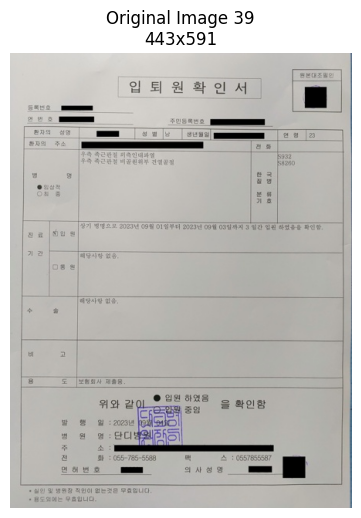

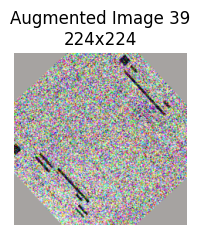

In [9]:
# 이미지 디렉토리와 인덱스 범위 설정
image_dir = train_dir
start_index = 39
end_index = 40

# 이미지 로드
image_paths = sorted(os.listdir(image_dir))[start_index:end_index]
images = [cv2.imread(os.path.join(image_dir, img_path)) for img_path in image_paths]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

# 변환 적용 및 시각화
for i, image in enumerate(images):
    # 변환 적용
    augmented = trn_transform(image=image)
    transformed_image = augmented['image'].permute(1, 2, 0).cpu().numpy()  # 텐서를 다시 이미지로 변환
    transformed_image = (transformed_image * np.array(std) + np.array(mean))  # 정규화를 되돌림
    transformed_image = (transformed_image * 255).astype(np.uint8)  # 이미지를 다시 0-255 범위로 변환

    # 원본 이미지 크기
    original_h, original_w, _ = image.shape
    # 변환된 이미지 크기
    transformed_h, transformed_w, = img_size, img_size

    # 각 이미지의 플롯 크기를 실제 이미지 크기의 1/100로 설정
    original_figsize = (original_w / 100, original_h / 100)
    transformed_figsize = (transformed_w / 100, transformed_h / 100)
    # print(f'original_figsize={original_figsize}',f'transformed_figsize={transformed_figsize}')

    # 원본 이미지 출력
    fig, ax = plt.subplots(1, 1, figsize=original_figsize)
    ax.imshow(image)
    ax.set_title(f'Original Image {i + start_index}\n{original_w}x{original_h}')
    ax.axis('off')
    # plt.tight_layout()
    plt.show()

    # 변환된 이미지 출력
    fig, ax = plt.subplots(1, 1, figsize=transformed_figsize)
    ax.imshow(transformed_image)
    ax.set_title(f'Augmented Image {i + start_index}\n{transformed_w}x{transformed_h}')
    ax.axis('off')
    # plt.tight_layout()
    plt.show()


### 3.3 하이퍼파라미터 설정 & 모델 학습

In [10]:
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [11]:
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [15]:
# Dataset 정의
trn_dataset = ImageDataset(
    train_csv_dir,
    train_dir,
    transform=trn_transform
)

print(len(trn_dataset))

1570


In [16]:
LR = 1e-4
BATCH_SIZE=128
num_workers=8
EPOCHS=100
patience=10

In [17]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)

In [18]:
# 시드 고정
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [19]:
# 모델 불러오기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [20]:
# 모델 이름
model_name = 'vit_base_patch16_224'

# 데이터 분리 (8:2)
def split_dataset(csv_path, train_dir):
    data = pd.read_csv(csv_path)
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=SEED, stratify=data['target'])

    train_csv_path = "/workspace/split_train.csv"
    val_csv_path =  "/workspace/split_val.csv"
    train_data.to_csv(train_csv_path, index=False)
    val_data.to_csv(val_csv_path, index=False)
    return train_csv_path, val_csv_path

train_csv_path, val_csv_path = split_dataset(train_csv_dir, train_dir)

# Validation Dataset 정의
val_dataset = ImageDataset(
    val_csv_path,
    train_dir,
    transform=trn_transform
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

# validation 평가 함수
def validate(loader, model, loss_fn, device, class_names=None, print_class_report=False):
    model.eval()
    val_loss = 0
    preds_list = []
    targets_list = []

    with torch.no_grad():
        for image, targets in loader:
            image = image.to(device)
            targets = targets.to(device)

            preds = model(image)
            loss = loss_fn(preds, targets)

            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

    val_loss /= len(loader)
    val_acc = accuracy_score(targets_list, preds_list)
    val_f1 = f1_score(targets_list, preds_list, average='macro')
    
    # 클래스별 F1 Score 계산
    if class_names:
        class_report = classification_report(
            targets_list,
            preds_list,
            target_names=class_names,
            zero_division=0
        )
        if print_class_report:  # 출력 여부 조건
            print("Classification Report:\n", class_report)
    else:
        class_report = None

    return {"val_loss": val_loss, "val_acc": val_acc, "val_f1": val_f1, "class_report": class_report}

# 체크포인트 저장 함수
def save_checkpoint(model, optimizer, epoch, filepath):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch
    }
    torch.save(checkpoint, filepath)

# 체크포인트 로드 함수
def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    return model, optimizer, start_epoch

In [58]:
# 모델 생성
print(f"Training {model_name}...")

# 모델 초기화
model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=0)  # Cosine Decay Scheduler
loss_fn = nn.CrossEntropyLoss()

# 학습 로그를 저장할 리스트 초기화
train_loss_log = []
train_acc_log = []
train_f1_log = []
val_loss_log = []
val_acc_log = []
val_f1_log = []

best_model_path = "/workspace/best_vit_base_patch16_224_best.pth"

best_val_loss = float("inf")  # 초기값을 큰 값으로 설정
patience_counter = 0

for epoch in range(EPOCHS):
    # Train
    train_metrics = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
    train_metrics['epoch'] = epoch

    # Validate
    val_metrics = validate(
        val_loader, 
        model, 
        loss_fn, 
        device, 
        class_names = [f"Class {i}" for i in range(17)],
    )
    train_metrics.update(val_metrics)

    # Step the scheduler
    scheduler.step()

    # Save metrics to logs
    train_loss_log.append(train_metrics['train_loss'])
    train_acc_log.append(train_metrics['train_acc'])
    train_f1_log.append(train_metrics['train_f1'])
    val_loss_log.append(val_metrics['val_loss'])
    val_acc_log.append(val_metrics['val_acc'])
    val_f1_log.append(val_metrics['val_f1'])

    # Log metrics
    log = f"Epoch {epoch+1}/{EPOCHS} - " + ", ".join(
        [f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}" for k, v in train_metrics.items()]
    )
    print(log)

    # Best Model 저장 (val_loss 기준)
    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        patience_counter = 0  # Reset patience counter
        save_checkpoint(model, optimizer, epoch, best_model_path)  # Best 모델 저장
        print(f"New best model saved at epoch {epoch+1} with Loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1

    # Early Stopping 조건 확인
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 학습 및 검증 로그를 DataFrame으로 변환
logs_df = pd.DataFrame({
    "epoch": range(len(train_loss_log)),
    "train_loss": train_loss_log,
    "train_acc": train_acc_log,
    "train_f1": train_f1_log,
    "val_loss": val_loss_log,
    "val_acc": val_acc_log,
    "val_f1": val_f1_log
})

Training vit_base_patch16_224...


Loss: 1.6367: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 1/100 - train_loss: 2.1570, train_acc: 0.3121, train_f1: 0.2752, epoch: 0, val_loss: 1.5719, val_acc: 0.4395, val_f1: 0.3982, class_report:               precision    recall  f1-score   support

     Class 0       1.00      0.90      0.95        20
     Class 1       0.00      0.00      0.00         9
     Class 2       1.00      0.90      0.95        20
     Class 3       0.33      0.05      0.09        20
     Class 4       0.00      0.00      0.00        20
     Class 5       0.45      1.00      0.62        20
     Class 6       0.67      0.30      0.41        20
     Class 7       0.12      0.70      0.20        20
     Class 8       1.00      0.15      0.26        20
     Class 9       0.75      0.60      0.67        20
    Class 10       0.50      0.10      0.17        20
    Class 11       1.00      0.30      0.46        20
    Class 12       0.71      0.25      0.37        20
    Class 13       0.32      0.40      0.35        15
    Class 14       0.00      0.00      0.00

Loss: 1.2249: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 2/100 - train_loss: 1.2522, train_acc: 0.5720, train_f1: 0.5413, epoch: 1, val_loss: 0.9941, val_acc: 0.6688, val_f1: 0.6327, class_report:               precision    recall  f1-score   support

     Class 0       1.00      0.90      0.95        20
     Class 1       0.50      0.56      0.53         9
     Class 2       1.00      0.80      0.89        20
     Class 3       0.00      0.00      0.00        20
     Class 4       0.30      0.30      0.30        20
     Class 5       0.95      0.95      0.95        20
     Class 6       0.63      0.85      0.72        20
     Class 7       0.24      0.70      0.36        20
     Class 8       1.00      0.90      0.95        20
     Class 9       0.95      1.00      0.98        20
    Class 10       0.65      0.55      0.59        20
    Class 11       0.79      0.75      0.77        20
    Class 12       0.48      0.70      0.57        20
    Class 13       0.70      0.47      0.56        15
    Class 14       0.00      0.00      0.00

Loss: 0.7471: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 3/100 - train_loss: 0.8954, train_acc: 0.6796, train_f1: 0.6472, epoch: 2, val_loss: 0.8962, val_acc: 0.6943, val_f1: 0.6593, class_report:               precision    recall  f1-score   support

     Class 0       0.95      1.00      0.98        20
     Class 1       1.00      0.22      0.36         9
     Class 2       1.00      0.85      0.92        20
     Class 3       0.29      0.25      0.27        20
     Class 4       0.23      0.85      0.36        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.94      0.75      0.83        20
     Class 7       0.00      0.00      0.00        20
     Class 8       1.00      0.95      0.97        20
     Class 9       1.00      0.95      0.97        20
    Class 10       0.73      0.40      0.52        20
    Class 11       0.70      0.95      0.81        20
    Class 12       0.65      0.55      0.59        20
    Class 13       0.90      0.60      0.72        15
    Class 14       0.00      0.00      0.00

Loss: 1.1941: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 4/100 - train_loss: 0.7586, train_acc: 0.7363, train_f1: 0.7151, epoch: 3, val_loss: 0.7023, val_acc: 0.7707, val_f1: 0.7286, class_report:               precision    recall  f1-score   support

     Class 0       0.95      0.90      0.92        20
     Class 1       1.00      0.67      0.80         9
     Class 2       0.95      1.00      0.98        20
     Class 3       0.31      0.85      0.45        20
     Class 4       0.62      0.25      0.36        20
     Class 5       0.95      1.00      0.98        20
     Class 6       0.90      0.95      0.93        20
     Class 7       0.50      0.05      0.09        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.89      0.85      0.87        20
    Class 11       0.56      0.95      0.70        20
    Class 12       1.00      0.50      0.67        20
    Class 13       0.62      0.87      0.72        15
    Class 14       0.00      0.00      0.00

Loss: 0.8710: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 5/100 - train_loss: 0.6660, train_acc: 0.7618, train_f1: 0.7348, epoch: 4, val_loss: 0.5373, val_acc: 0.8217, val_f1: 0.8012, class_report:               precision    recall  f1-score   support

     Class 0       1.00      0.95      0.97        20
     Class 1       1.00      0.67      0.80         9
     Class 2       1.00      0.90      0.95        20
     Class 3       0.50      0.50      0.50        20
     Class 4       0.53      0.50      0.51        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.77      1.00      0.87        20
     Class 7       0.75      0.15      0.25        20
     Class 8       1.00      1.00      1.00        20
     Class 9       0.95      1.00      0.98        20
    Class 10       0.84      0.80      0.82        20
    Class 11       1.00      0.95      0.97        20
    Class 12       0.70      0.95      0.81        20
    Class 13       0.80      0.80      0.80        15
    Class 14       0.29      0.60      0.39

Loss: 0.5299: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 6/100 - train_loss: 0.5788, train_acc: 0.7968, train_f1: 0.7724, epoch: 5, val_loss: 0.6029, val_acc: 0.7930, val_f1: 0.7626, class_report:               precision    recall  f1-score   support

     Class 0       0.90      0.95      0.93        20
     Class 1       0.80      0.44      0.57         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.61      0.55      0.58        20
     Class 4       0.54      0.65      0.59        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.59      1.00      0.74        20
     Class 7       0.43      0.15      0.22        20
     Class 8       1.00      0.95      0.97        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      0.45      0.62        20
    Class 11       1.00      0.95      0.97        20
    Class 12       0.56      0.95      0.70        20
    Class 13       1.00      0.67      0.80        15
    Class 14       0.40      0.40      0.40

Loss: 0.4985: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 7/100 - train_loss: 0.5075, train_acc: 0.8140, train_f1: 0.7863, epoch: 6, val_loss: 0.4546, val_acc: 0.8408, val_f1: 0.8311, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       0.70      0.78      0.74         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.44      0.55      0.49        20
     Class 4       0.72      0.65      0.68        20
     Class 5       0.91      1.00      0.95        20
     Class 6       0.95      0.95      0.95        20
     Class 7       0.36      0.40      0.38        20
     Class 8       1.00      0.95      0.97        20
     Class 9       0.95      1.00      0.98        20
    Class 10       0.94      0.80      0.86        20
    Class 11       0.90      0.95      0.93        20
    Class 12       1.00      0.85      0.92        20
    Class 13       0.86      0.80      0.83        15
    Class 14       0.50      0.50      0.50

Loss: 0.5462: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 8/100 - train_loss: 0.4774, train_acc: 0.8363, train_f1: 0.8194, epoch: 7, val_loss: 0.3728, val_acc: 0.8790, val_f1: 0.8615, class_report:               precision    recall  f1-score   support

     Class 0       0.95      1.00      0.98        20
     Class 1       1.00      0.78      0.88         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.82      0.45      0.58        20
     Class 4       0.57      0.80      0.67        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.95      0.95      0.95        20
     Class 7       0.50      0.55      0.52        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.83      1.00      0.91        20
    Class 11       0.83      1.00      0.91        20
    Class 12       0.86      0.95      0.90        20
    Class 13       1.00      0.80      0.89        15
    Class 14       1.00      0.30      0.46

Loss: 0.5466: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 9/100 - train_loss: 0.4202, train_acc: 0.8497, train_f1: 0.8344, epoch: 8, val_loss: 0.4778, val_acc: 0.8312, val_f1: 0.7924, class_report:               precision    recall  f1-score   support

     Class 0       1.00      0.90      0.95        20
     Class 1       0.88      0.78      0.82         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.65      0.65      0.65        20
     Class 4       0.45      0.95      0.61        20
     Class 5       0.91      1.00      0.95        20
     Class 6       1.00      0.85      0.92        20
     Class 7       0.71      0.25      0.37        20
     Class 8       1.00      0.90      0.95        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.82      0.90      0.86        20
    Class 11       0.83      1.00      0.91        20
    Class 12       0.71      0.85      0.77        20
    Class 13       0.85      0.73      0.79        15
    Class 14       0.00      0.00      0.00

Loss: 0.4170: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 10/100 - train_loss: 0.4037, train_acc: 0.8389, train_f1: 0.8204, epoch: 9, val_loss: 0.3863, val_acc: 0.8822, val_f1: 0.8726, class_report:               precision    recall  f1-score   support

     Class 0       0.91      1.00      0.95        20
     Class 1       1.00      0.78      0.88         9
     Class 2       0.91      1.00      0.95        20
     Class 3       0.80      0.40      0.53        20
     Class 4       0.64      0.90      0.75        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.90      0.95      0.93        20
     Class 7       0.55      0.55      0.55        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.90      0.95      0.93        20
    Class 11       0.83      1.00      0.91        20
    Class 12       1.00      0.85      0.92        20
    Class 13       1.00      0.80      0.89        15
    Class 14       0.70      0.70      0.7

Loss: 0.5636: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 11/100 - train_loss: 0.4221, train_acc: 0.8522, train_f1: 0.8348, epoch: 10, val_loss: 0.3658, val_acc: 0.8631, val_f1: 0.8531, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.78      0.88         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.40      0.85      0.55        20
     Class 4       0.65      0.65      0.65        20
     Class 5       0.95      1.00      0.98        20
     Class 6       1.00      0.95      0.97        20
     Class 7       0.60      0.15      0.24        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.86      0.90      0.88        20
    Class 11       0.89      0.85      0.87        20
    Class 12       0.95      0.90      0.92        20
    Class 13       1.00      0.93      0.97        15
    Class 14       0.83      0.50      0.

Loss: 0.3618: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 12/100 - train_loss: 0.3721, train_acc: 0.8637, train_f1: 0.8525, epoch: 11, val_loss: 0.3600, val_acc: 0.8631, val_f1: 0.8383, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.78      0.88         9
     Class 2       1.00      0.95      0.97        20
     Class 3       0.67      0.10      0.17        20
     Class 4       0.55      0.90      0.68        20
     Class 5       0.95      1.00      0.98        20
     Class 6       0.87      1.00      0.93        20
     Class 7       0.45      0.65      0.53        20
     Class 8       1.00      0.90      0.95        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      0.85      0.92        20
    Class 11       0.90      0.95      0.93        20
    Class 12       0.95      1.00      0.98        20
    Class 13       0.79      1.00      0.88        15
    Class 14       1.00      0.30      0.

Loss: 0.3735: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 13/100 - train_loss: 0.3588, train_acc: 0.8675, train_f1: 0.8532, epoch: 12, val_loss: 0.3132, val_acc: 0.8917, val_f1: 0.8886, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.78      0.88         9
     Class 2       1.00      0.95      0.97        20
     Class 3       0.62      0.40      0.48        20
     Class 4       0.76      0.95      0.84        20
     Class 5       0.95      1.00      0.98        20
     Class 6       0.83      1.00      0.91        20
     Class 7       0.50      0.70      0.58        20
     Class 8       1.00      0.95      0.97        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      0.85      0.92        20
    Class 11       1.00      0.90      0.95        20
    Class 12       0.95      0.95      0.95        20
    Class 13       1.00      0.93      0.97        15
    Class 14       0.88      0.70      0.

Loss: 0.4907: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 14/100 - train_loss: 0.3618, train_acc: 0.8682, train_f1: 0.8517, epoch: 13, val_loss: 0.3314, val_acc: 0.8854, val_f1: 0.8657, class_report:               precision    recall  f1-score   support

     Class 0       1.00      0.95      0.97        20
     Class 1       0.70      0.78      0.74         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.58      0.95      0.72        20
     Class 4       0.76      0.80      0.78        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      0.95      0.97        20
     Class 7       0.78      0.35      0.48        20
     Class 8       1.00      1.00      1.00        20
     Class 9       0.95      1.00      0.98        20
    Class 10       0.94      0.85      0.89        20
    Class 11       0.83      0.95      0.88        20
    Class 12       0.91      1.00      0.95        20
    Class 13       0.92      0.73      0.81        15
    Class 14       0.62      0.50      0.

Loss: 0.2873: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 15/100 - train_loss: 0.3584, train_acc: 0.8656, train_f1: 0.8572, epoch: 14, val_loss: 0.3498, val_acc: 0.8917, val_f1: 0.8883, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       0.95      1.00      0.98        20
     Class 3       0.86      0.30      0.44        20
     Class 4       0.58      0.95      0.72        20
     Class 5       0.95      1.00      0.98        20
     Class 6       0.95      0.90      0.92        20
     Class 7       0.56      0.70      0.62        20
     Class 8       1.00      0.95      0.97        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.94      0.85      0.89        20
    Class 11       0.87      1.00      0.93        20
    Class 12       0.95      1.00      0.98        20
    Class 13       1.00      0.87      0.93        15
    Class 14       1.00      0.70      0.

Loss: 0.4446: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 16/100 - train_loss: 0.3605, train_acc: 0.8745, train_f1: 0.8585, epoch: 15, val_loss: 0.3109, val_acc: 0.9140, val_f1: 0.9018, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.78      0.88         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.76      0.65      0.70        20
     Class 4       0.73      0.95      0.83        20
     Class 5       0.95      1.00      0.98        20
     Class 6       0.90      0.95      0.93        20
     Class 7       0.77      0.50      0.61        20
     Class 8       1.00      0.95      0.97        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.95      1.00      0.98        20
    Class 11       0.95      1.00      0.98        20
    Class 12       0.95      0.95      0.95        20
    Class 13       0.93      0.93      0.93        15
    Class 14       0.54      0.70      0.

Loss: 0.4991: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 17/100 - train_loss: 0.3769, train_acc: 0.8605, train_f1: 0.8507, epoch: 16, val_loss: 0.3281, val_acc: 0.8822, val_f1: 0.8690, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       0.75      1.00      0.86         9
     Class 2       1.00      0.95      0.97        20
     Class 3       0.80      0.20      0.32        20
     Class 4       0.82      0.90      0.86        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.95      0.95      0.95        20
     Class 7       0.45      0.75      0.57        20
     Class 8       1.00      1.00      1.00        20
     Class 9       0.95      1.00      0.98        20
    Class 10       0.90      0.95      0.93        20
    Class 11       0.95      0.90      0.92        20
    Class 12       1.00      0.85      0.92        20
    Class 13       0.86      0.80      0.83        15
    Class 14       0.70      0.70      0.

Loss: 0.3286: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 18/100 - train_loss: 0.3296, train_acc: 0.8732, train_f1: 0.8651, epoch: 17, val_loss: 0.3074, val_acc: 0.9013, val_f1: 0.8890, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.55      0.85      0.67        20
     Class 4       0.78      0.90      0.84        20
     Class 5       0.91      1.00      0.95        20
     Class 6       1.00      0.90      0.95        20
     Class 7       0.60      0.45      0.51        20
     Class 8       1.00      0.95      0.97        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.95      0.95      0.95        20
    Class 11       1.00      0.95      0.97        20
    Class 12       0.90      0.95      0.93        20
    Class 13       0.93      0.93      0.93        15
    Class 14       1.00      0.30      0.

Loss: 0.2937: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 19/100 - train_loss: 0.3123, train_acc: 0.8892, train_f1: 0.8752, epoch: 18, val_loss: 0.2935, val_acc: 0.8949, val_f1: 0.8849, class_report:               precision    recall  f1-score   support

     Class 0       1.00      0.95      0.97        20
     Class 1       0.78      0.78      0.78         9
     Class 2       0.95      1.00      0.98        20
     Class 3       0.83      0.50      0.62        20
     Class 4       0.69      0.90      0.78        20
     Class 5       0.91      1.00      0.95        20
     Class 6       0.91      1.00      0.95        20
     Class 7       0.54      0.70      0.61        20
     Class 8       1.00      1.00      1.00        20
     Class 9       0.95      1.00      0.98        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      0.85      0.92        20
    Class 12       0.95      0.90      0.92        20
    Class 13       0.93      0.87      0.90        15
    Class 14       0.86      0.60      0.

Loss: 0.3813: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 20/100 - train_loss: 0.2973, train_acc: 0.8955, train_f1: 0.8866, epoch: 19, val_loss: 0.2378, val_acc: 0.9236, val_f1: 0.9178, class_report:               precision    recall  f1-score   support

     Class 0       0.95      1.00      0.98        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      0.95      0.97        20
     Class 3       0.92      0.55      0.69        20
     Class 4       0.70      0.95      0.81        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.95      1.00      0.98        20
     Class 7       0.64      0.70      0.67        20
     Class 8       0.95      1.00      0.98        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       0.95      0.95      0.95        20
    Class 12       1.00      0.90      0.95        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.70      0.70      0.

Loss: 0.4725: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 21/100 - train_loss: 0.2906, train_acc: 0.8955, train_f1: 0.8870, epoch: 20, val_loss: 0.2719, val_acc: 0.9045, val_f1: 0.8895, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.78      0.88         9
     Class 2       1.00      0.90      0.95        20
     Class 3       0.57      1.00      0.73        20
     Class 4       0.80      0.80      0.80        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.91      1.00      0.95        20
     Class 7       1.00      0.25      0.40        20
     Class 8       0.95      1.00      0.98        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      0.90      0.95        20
    Class 11       0.95      1.00      0.98        20
    Class 12       1.00      0.90      0.95        20
    Class 13       0.88      1.00      0.94        15
    Class 14       0.58      0.70      0.

Loss: 0.2910: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 22/100 - train_loss: 0.2700, train_acc: 0.9000, train_f1: 0.8910, epoch: 21, val_loss: 0.2426, val_acc: 0.9299, val_f1: 0.9244, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      0.95      0.97        20
     Class 3       0.77      0.85      0.81        20
     Class 4       0.88      0.70      0.78        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.95      1.00      0.98        20
     Class 7       0.69      0.55      0.61        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.87      1.00      0.93        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      0.95      0.97        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.60      0.90      0.

Loss: 0.4697: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 23/100 - train_loss: 0.2601, train_acc: 0.9102, train_f1: 0.9042, epoch: 22, val_loss: 0.2317, val_acc: 0.9236, val_f1: 0.9208, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       0.90      1.00      0.95         9
     Class 2       1.00      0.95      0.97        20
     Class 3       0.80      0.60      0.69        20
     Class 4       0.75      0.90      0.82        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      0.95      0.97        20
     Class 7       0.62      0.65      0.63        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.86      0.95      0.90        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      0.95      0.97        20
    Class 13       1.00      0.93      0.97        15
    Class 14       0.80      0.80      0.

Loss: 0.4219: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 24/100 - train_loss: 0.2506, train_acc: 0.9032, train_f1: 0.8935, epoch: 23, val_loss: 0.2304, val_acc: 0.9268, val_f1: 0.9174, class_report:               precision    recall  f1-score   support

     Class 0       1.00      0.95      0.97        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      0.95      0.97        20
     Class 3       0.74      0.70      0.72        20
     Class 4       0.86      0.90      0.88        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.95      0.90      0.92        20
     Class 7       0.74      0.70      0.72        20
     Class 8       1.00      1.00      1.00        20
     Class 9       0.95      1.00      0.98        20
    Class 10       0.95      1.00      0.98        20
    Class 11       0.95      1.00      0.98        20
    Class 12       0.91      1.00      0.95        20
    Class 13       0.94      1.00      0.97        15
    Class 14       0.71      0.50      0.

Loss: 0.4898: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 25/100 - train_loss: 0.2851, train_acc: 0.8955, train_f1: 0.8912, epoch: 24, val_loss: 0.2681, val_acc: 0.9108, val_f1: 0.9073, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.78      0.88         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.67      0.60      0.63        20
     Class 4       0.88      0.75      0.81        20
     Class 5       1.00      0.90      0.95        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.60      0.75      0.67        20
     Class 8       0.91      1.00      0.95        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.95      1.00      0.98        20
    Class 11       0.91      1.00      0.95        20
    Class 12       0.94      0.85      0.89        20
    Class 13       0.82      0.93      0.88        15
    Class 14       0.89      0.80      0.

Loss: 0.1963: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 26/100 - train_loss: 0.2331, train_acc: 0.9064, train_f1: 0.8965, epoch: 25, val_loss: 0.1989, val_acc: 0.9427, val_f1: 0.9378, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.84      0.80      0.82        20
     Class 4       0.85      0.85      0.85        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      0.95      0.97        20
     Class 7       0.74      0.70      0.72        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.87      1.00      0.93        20
    Class 11       1.00      1.00      1.00        20
    Class 12       0.87      1.00      0.93        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.88      0.70      0.

Loss: 0.2799: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 27/100 - train_loss: 0.2735, train_acc: 0.9000, train_f1: 0.8926, epoch: 26, val_loss: 0.2195, val_acc: 0.9236, val_f1: 0.9192, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       1.00      0.35      0.52        20
     Class 4       0.84      0.80      0.82        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      0.95      0.97        20
     Class 7       0.52      0.75      0.61        20
     Class 8       0.95      1.00      0.98        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.95      1.00      0.98        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.64      0.90      0.

Loss: 0.2595: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 28/100 - train_loss: 0.2588, train_acc: 0.9102, train_f1: 0.9050, epoch: 27, val_loss: 0.2353, val_acc: 0.9076, val_f1: 0.9005, class_report:               precision    recall  f1-score   support

     Class 0       0.95      1.00      0.98        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.62      0.25      0.36        20
     Class 4       0.81      0.85      0.83        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.53      0.85      0.65        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      0.95      0.97        20
    Class 11       0.91      1.00      0.95        20
    Class 12       0.87      1.00      0.93        20
    Class 13       0.93      0.87      0.90        15
    Class 14       1.00      0.70      0.

Loss: 0.4321: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 29/100 - train_loss: 0.2535, train_acc: 0.9076, train_f1: 0.9018, epoch: 28, val_loss: 0.2043, val_acc: 0.9427, val_f1: 0.9376, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.78      0.88         9
     Class 2       1.00      1.00      1.00        20
     Class 3       1.00      0.55      0.71        20
     Class 4       0.74      0.85      0.79        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.95      1.00      0.98        20
     Class 7       0.68      0.85      0.76        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       0.95      1.00      0.98        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.82      0.90      0.

Loss: 0.2715: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 30/100 - train_loss: 0.2497, train_acc: 0.9083, train_f1: 0.9013, epoch: 29, val_loss: 0.2394, val_acc: 0.9108, val_f1: 0.9041, class_report:               precision    recall  f1-score   support

     Class 0       1.00      0.95      0.97        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.56      1.00      0.71        20
     Class 4       0.87      0.65      0.74        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      0.95      0.97        20
     Class 7       0.83      0.25      0.38        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.91      1.00      0.95        20
    Class 11       1.00      1.00      1.00        20
    Class 12       0.91      1.00      0.95        20
    Class 13       1.00      0.87      0.93        15
    Class 14       0.90      0.90      0.

Loss: 0.1633: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 31/100 - train_loss: 0.2141, train_acc: 0.9191, train_f1: 0.9129, epoch: 30, val_loss: 0.2038, val_acc: 0.9363, val_f1: 0.9305, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       0.90      1.00      0.95         9
     Class 2       0.95      1.00      0.98        20
     Class 3       0.79      0.75      0.77        20
     Class 4       0.89      0.85      0.87        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      0.95      0.97        20
     Class 7       0.65      0.65      0.65        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.95      1.00      0.98        20
    Class 11       1.00      1.00      1.00        20
    Class 12       0.91      1.00      0.95        20
    Class 13       1.00      0.93      0.97        15
    Class 14       0.78      0.70      0.

Loss: 0.2604: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 32/100 - train_loss: 0.1937, train_acc: 0.9229, train_f1: 0.9157, epoch: 31, val_loss: 0.1801, val_acc: 0.9490, val_f1: 0.9448, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.78      0.90      0.84        20
     Class 4       0.95      0.90      0.92        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.70      0.70      0.70        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       0.95      0.95      0.95        20
    Class 12       1.00      0.90      0.95        20
    Class 13       0.94      1.00      0.97        15
    Class 14       0.78      0.70      0.

Loss: 0.4664: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 33/100 - train_loss: 0.2292, train_acc: 0.9280, train_f1: 0.9228, epoch: 32, val_loss: 0.1640, val_acc: 0.9427, val_f1: 0.9363, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.86      0.90      0.88        20
     Class 4       0.77      1.00      0.87        20
     Class 5       1.00      0.95      0.97        20
     Class 6       1.00      0.95      0.97        20
     Class 7       0.77      0.50      0.61        20
     Class 8       0.95      1.00      0.98        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.95      1.00      0.98        20
    Class 11       0.91      1.00      0.95        20
    Class 12       1.00      0.95      0.97        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.78      0.70      0.

Loss: 0.1407: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 34/100 - train_loss: 0.2205, train_acc: 0.9146, train_f1: 0.9097, epoch: 33, val_loss: 0.1926, val_acc: 0.9236, val_f1: 0.9172, class_report:               precision    recall  f1-score   support

     Class 0       0.95      1.00      0.98        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.65      0.75      0.70        20
     Class 4       0.62      0.90      0.73        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.83      0.50      0.62        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      0.95      0.97        20
    Class 12       0.95      0.95      0.95        20
    Class 13       0.94      1.00      0.97        15
    Class 14       1.00      0.50      0.

Loss: 0.3483: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 35/100 - train_loss: 0.2170, train_acc: 0.9223, train_f1: 0.9187, epoch: 34, val_loss: 0.1626, val_acc: 0.9490, val_f1: 0.9505, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      0.95      0.97        20
     Class 3       0.72      0.90      0.80        20
     Class 4       0.80      0.80      0.80        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.80      0.60      0.69        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       0.95      1.00      0.98        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       1.00      0.90      0.

Loss: 0.2750: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 36/100 - train_loss: 0.2030, train_acc: 0.9280, train_f1: 0.9224, epoch: 35, val_loss: 0.1574, val_acc: 0.9363, val_f1: 0.9330, class_report:               precision    recall  f1-score   support

     Class 0       1.00      0.95      0.97        20
     Class 1       1.00      0.89      0.94         9
     Class 2       0.95      1.00      0.98        20
     Class 3       0.69      0.90      0.78        20
     Class 4       0.76      0.95      0.84        20
     Class 5       0.95      1.00      0.98        20
     Class 6       0.95      1.00      0.98        20
     Class 7       0.90      0.45      0.60        20
     Class 8       1.00      0.95      0.97        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      0.95      0.97        20
    Class 12       1.00      0.95      0.97        20
    Class 13       0.94      1.00      0.97        15
    Class 14       0.90      0.90      0.

Loss: 0.3316: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 37/100 - train_loss: 0.1987, train_acc: 0.9325, train_f1: 0.9258, epoch: 36, val_loss: 0.1464, val_acc: 0.9427, val_f1: 0.9380, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.79      0.75      0.77        20
     Class 4       0.83      0.75      0.79        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.72      0.90      0.80        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      0.95      0.97        20
    Class 11       0.95      1.00      0.98        20
    Class 12       0.95      1.00      0.98        20
    Class 13       0.94      1.00      0.97        15
    Class 14       0.88      0.70      0.

Loss: 0.1193: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 38/100 - train_loss: 0.1762, train_acc: 0.9363, train_f1: 0.9286, epoch: 37, val_loss: 0.2104, val_acc: 0.9427, val_f1: 0.9375, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.81      0.85      0.83        20
     Class 4       0.94      0.80      0.86        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.95      1.00      0.98        20
     Class 7       0.79      0.75      0.77        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      0.95      0.97        20
    Class 11       0.87      1.00      0.93        20
    Class 12       0.95      0.90      0.92        20
    Class 13       0.94      1.00      0.97        15
    Class 14       0.73      0.80      0.

Loss: 0.3070: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 39/100 - train_loss: 0.1969, train_acc: 0.9395, train_f1: 0.9362, epoch: 38, val_loss: 0.1498, val_acc: 0.9490, val_f1: 0.9434, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.85      0.85      0.85        20
     Class 4       0.94      0.85      0.89        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.88      0.70      0.78        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.95      1.00      0.98        20
    Class 11       0.95      0.95      0.95        20
    Class 12       0.95      0.95      0.95        20
    Class 13       0.94      1.00      0.97        15
    Class 14       0.62      0.80      0.

Loss: 0.1848: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 40/100 - train_loss: 0.1582, train_acc: 0.9465, train_f1: 0.9447, epoch: 39, val_loss: 0.1627, val_acc: 0.9459, val_f1: 0.9388, class_report:               precision    recall  f1-score   support

     Class 0       0.95      1.00      0.98        20
     Class 1       1.00      0.78      0.88         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.78      0.90      0.84        20
     Class 4       0.79      0.95      0.86        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.92      0.55      0.69        20
     Class 8       1.00      1.00      1.00        20
     Class 9       0.95      1.00      0.98        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      0.95      0.97        20
    Class 12       0.91      1.00      0.95        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.89      0.80      0.

Loss: 0.4601: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 41/100 - train_loss: 0.1773, train_acc: 0.9389, train_f1: 0.9384, epoch: 40, val_loss: 0.1278, val_acc: 0.9618, val_f1: 0.9583, class_report:               precision    recall  f1-score   support

     Class 0       0.95      1.00      0.98        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      0.95      0.97        20
     Class 3       0.89      0.85      0.87        20
     Class 4       0.86      0.90      0.88        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       1.00      0.75      0.86        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.95      1.00      0.98        20
    Class 11       1.00      1.00      1.00        20
    Class 12       0.95      1.00      0.98        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.69      0.90      0.

Loss: 0.2078: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 42/100 - train_loss: 0.1876, train_acc: 0.9299, train_f1: 0.9267, epoch: 41, val_loss: 0.1716, val_acc: 0.9427, val_f1: 0.9408, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.92      0.55      0.69        20
     Class 4       0.82      0.90      0.86        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.61      0.85      0.71        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       0.91      1.00      0.95        20
    Class 13       1.00      0.93      0.97        15
    Class 14       1.00      0.70      0.

Loss: 0.0974: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 43/100 - train_loss: 0.1773, train_acc: 0.9306, train_f1: 0.9275, epoch: 42, val_loss: 0.1448, val_acc: 0.9395, val_f1: 0.9363, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.88      0.70      0.78        20
     Class 4       0.88      0.70      0.78        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.71      0.75      0.73        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.91      1.00      0.95        20
    Class 11       1.00      0.95      0.97        20
    Class 12       0.91      1.00      0.95        20
    Class 13       0.94      1.00      0.97        15
    Class 14       0.69      0.90      0.

Loss: 0.1557: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 44/100 - train_loss: 0.1643, train_acc: 0.9401, train_f1: 0.9365, epoch: 43, val_loss: 0.1711, val_acc: 0.9554, val_f1: 0.9491, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.90      0.90      0.90        20
     Class 4       1.00      0.75      0.86        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.89      0.80      0.84        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      0.95      0.97        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.47      0.90      0.

Loss: 0.1593: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 45/100 - train_loss: 0.1626, train_acc: 0.9427, train_f1: 0.9365, epoch: 44, val_loss: 0.1486, val_acc: 0.9427, val_f1: 0.9419, class_report:               precision    recall  f1-score   support

     Class 0       1.00      0.95      0.97        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.77      0.85      0.81        20
     Class 4       0.88      0.70      0.78        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.67      0.80      0.73        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      0.95      0.97        20
    Class 12       1.00      1.00      1.00        20
    Class 13       0.94      1.00      0.97        15
    Class 14       1.00      0.80      0.

Loss: 0.0669: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 46/100 - train_loss: 0.1504, train_acc: 0.9452, train_f1: 0.9413, epoch: 45, val_loss: 0.1378, val_acc: 0.9490, val_f1: 0.9426, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.78      0.88         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.73      0.95      0.83        20
     Class 4       0.88      0.75      0.81        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.93      0.65      0.76        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.87      1.00      0.93        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.75      0.90      0.

Loss: 0.1753: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 47/100 - train_loss: 0.1523, train_acc: 0.9382, train_f1: 0.9335, epoch: 46, val_loss: 0.1548, val_acc: 0.9522, val_f1: 0.9456, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      0.95      0.97        20
     Class 3       0.86      0.90      0.88        20
     Class 4       0.86      0.90      0.88        20
     Class 5       0.95      1.00      0.98        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.83      0.75      0.79        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       0.91      1.00      0.95        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.78      0.70      0.

Loss: 0.1196: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 48/100 - train_loss: 0.1445, train_acc: 0.9497, train_f1: 0.9428, epoch: 47, val_loss: 0.1343, val_acc: 0.9650, val_f1: 0.9615, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.95      0.95      0.95        20
     Class 4       0.89      0.85      0.87        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.84      0.80      0.82        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.91      1.00      0.95        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      0.95      0.97        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.80      0.80      0.

Loss: 0.1698: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 49/100 - train_loss: 0.1489, train_acc: 0.9369, train_f1: 0.9309, epoch: 48, val_loss: 0.1330, val_acc: 0.9554, val_f1: 0.9567, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       1.00      0.60      0.75        20
     Class 4       0.94      0.85      0.89        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.60      0.90      0.72        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.90      0.90      0.

Loss: 0.2090: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 50/100 - train_loss: 0.1400, train_acc: 0.9471, train_f1: 0.9429, epoch: 49, val_loss: 0.1132, val_acc: 0.9522, val_f1: 0.9481, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       0.89      0.89      0.89         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.80      0.80      0.80        20
     Class 4       0.90      0.90      0.90        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.78      0.70      0.74        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.95      1.00      0.98        20
    Class 11       0.95      1.00      0.98        20
    Class 12       0.91      1.00      0.95        20
    Class 13       1.00      1.00      1.00        15
    Class 14       1.00      0.80      0.

Loss: 0.0941: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 51/100 - train_loss: 0.1350, train_acc: 0.9503, train_f1: 0.9470, epoch: 50, val_loss: 0.2000, val_acc: 0.9682, val_f1: 0.9652, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.95      0.90      0.92        20
     Class 4       0.90      0.90      0.90        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.80      0.80      0.80        20
     Class 8       1.00      1.00      1.00        20
     Class 9       0.95      1.00      0.98        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       0.94      1.00      0.97        15
    Class 14       0.90      0.90      0.

Loss: 0.3882: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 52/100 - train_loss: 0.1401, train_acc: 0.9541, train_f1: 0.9522, epoch: 51, val_loss: 0.1474, val_acc: 0.9490, val_f1: 0.9428, class_report:               precision    recall  f1-score   support

     Class 0       1.00      0.95      0.97        20
     Class 1       0.90      1.00      0.95         9
     Class 2       1.00      0.95      0.97        20
     Class 3       0.71      1.00      0.83        20
     Class 4       0.93      0.70      0.80        20
     Class 5       0.95      1.00      0.98        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.88      0.75      0.81        20
     Class 8       0.95      1.00      0.98        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.78      0.70      0.

Loss: 0.3955: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 53/100 - train_loss: 0.1715, train_acc: 0.9459, train_f1: 0.9398, epoch: 52, val_loss: 0.1807, val_acc: 0.9490, val_f1: 0.9460, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       1.00      0.80      0.89        20
     Class 4       0.94      0.80      0.86        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.63      0.95      0.76        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       0.90      0.90      0.90        20
    Class 13       0.88      0.93      0.90        15
    Class 14       1.00      0.70      0.

Loss: 0.1935: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 54/100 - train_loss: 0.1604, train_acc: 0.9465, train_f1: 0.9437, epoch: 53, val_loss: 0.1208, val_acc: 0.9745, val_f1: 0.9698, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.87      1.00      0.93        20
     Class 4       1.00      0.95      0.97        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.93      0.70      0.80        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.69      0.90      0.

Loss: 0.2532: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 55/100 - train_loss: 0.1523, train_acc: 0.9484, train_f1: 0.9451, epoch: 54, val_loss: 0.0960, val_acc: 0.9745, val_f1: 0.9726, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      0.95      0.97        20
     Class 3       0.95      0.95      0.95        20
     Class 4       0.83      1.00      0.91        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.95      1.00      0.98        20
     Class 7       1.00      0.85      0.92        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       0.95      1.00      0.98        20
    Class 13       1.00      0.93      0.97        15
    Class 14       1.00      0.80      0.

Loss: 0.1143: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 56/100 - train_loss: 0.1205, train_acc: 0.9605, train_f1: 0.9566, epoch: 55, val_loss: 0.1045, val_acc: 0.9682, val_f1: 0.9641, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.94      0.80      0.86        20
     Class 4       0.95      1.00      0.98        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.74      0.85      0.79        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       0.95      1.00      0.98        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.89      0.80      0.

Loss: 0.1159: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 57/100 - train_loss: 0.1133, train_acc: 0.9592, train_f1: 0.9538, epoch: 56, val_loss: 0.0944, val_acc: 0.9713, val_f1: 0.9702, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       0.90      1.00      0.95         9
     Class 2       1.00      1.00      1.00        20
     Class 3       1.00      0.85      0.92        20
     Class 4       0.95      0.90      0.92        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.81      0.85      0.83        20
     Class 8       0.95      1.00      0.98        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.95      1.00      0.98        20
    Class 11       1.00      1.00      1.00        20
    Class 12       0.95      1.00      0.98        20
    Class 13       1.00      1.00      1.00        15
    Class 14       1.00      0.90      0.

Loss: 0.2454: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 58/100 - train_loss: 0.1348, train_acc: 0.9599, train_f1: 0.9567, epoch: 57, val_loss: 0.1017, val_acc: 0.9618, val_f1: 0.9611, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       0.95      0.95      0.95        20
     Class 3       0.74      1.00      0.85        20
     Class 4       0.94      0.85      0.89        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       1.00      0.70      0.82        20
     Class 8       1.00      1.00      1.00        20
     Class 9       0.95      1.00      0.98        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      0.95      0.97        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.91      1.00      0.

Loss: 0.1790: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 59/100 - train_loss: 0.1113, train_acc: 0.9548, train_f1: 0.9488, epoch: 58, val_loss: 0.1092, val_acc: 0.9713, val_f1: 0.9678, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.95      0.95      0.95        20
     Class 4       0.94      0.80      0.86        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.78      0.90      0.84        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.80      0.80      0.

Loss: 0.2257: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 60/100 - train_loss: 0.1208, train_acc: 0.9611, train_f1: 0.9586, epoch: 59, val_loss: 0.0901, val_acc: 0.9745, val_f1: 0.9732, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.91      1.00      0.95        20
     Class 4       0.89      0.85      0.87        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.84      0.80      0.82        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.90      0.90      0.

Loss: 0.2439: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 61/100 - train_loss: 0.1007, train_acc: 0.9669, train_f1: 0.9629, epoch: 60, val_loss: 0.1096, val_acc: 0.9682, val_f1: 0.9665, class_report:               precision    recall  f1-score   support

     Class 0       1.00      0.95      0.97        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      0.95      0.97        20
     Class 3       1.00      0.90      0.95        20
     Class 4       0.86      0.95      0.90        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.84      0.80      0.82        20
     Class 8       0.95      1.00      0.98        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.82      0.90      0.

Loss: 0.1802: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 62/100 - train_loss: 0.1124, train_acc: 0.9637, train_f1: 0.9600, epoch: 61, val_loss: 0.1268, val_acc: 0.9586, val_f1: 0.9544, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       0.95      1.00      0.98        20
     Class 3       0.79      0.95      0.86        20
     Class 4       0.95      0.90      0.92        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.94      0.75      0.83        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      0.95      0.97        20
    Class 12       0.95      0.95      0.95        20
    Class 13       0.94      1.00      0.97        15
    Class 14       0.73      0.80      0.

Loss: 0.3194: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 63/100 - train_loss: 0.1111, train_acc: 0.9624, train_f1: 0.9598, epoch: 62, val_loss: 0.0832, val_acc: 0.9745, val_f1: 0.9683, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.94      0.85      0.89        20
     Class 4       0.90      0.95      0.93        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.90      0.95      0.93        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.95      1.00      0.98        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.78      0.70      0.

Loss: 0.0324: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 64/100 - train_loss: 0.0966, train_acc: 0.9611, train_f1: 0.9571, epoch: 63, val_loss: 0.0701, val_acc: 0.9777, val_f1: 0.9752, class_report:               precision    recall  f1-score   support

     Class 0       1.00      0.95      0.97        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.91      1.00      0.95        20
     Class 4       0.95      0.95      0.95        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       1.00      0.75      0.86        20
     Class 8       0.95      1.00      0.98        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.77      1.00      0.

Loss: 0.1145: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 65/100 - train_loss: 0.1087, train_acc: 0.9618, train_f1: 0.9574, epoch: 64, val_loss: 0.1064, val_acc: 0.9713, val_f1: 0.9691, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.91      1.00      0.95        20
     Class 4       0.86      0.90      0.88        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.95      1.00      0.98        20
     Class 7       0.94      0.85      0.89        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      0.90      0.95        20
    Class 13       0.88      1.00      0.94        15
    Class 14       1.00      0.90      0.

Loss: 0.1388: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 66/100 - train_loss: 0.0814, train_acc: 0.9682, train_f1: 0.9654, epoch: 65, val_loss: 0.0837, val_acc: 0.9809, val_f1: 0.9784, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      0.95      0.97        20
     Class 3       0.95      0.95      0.95        20
     Class 4       0.95      0.95      0.95        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.90      0.95      0.93        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       0.94      1.00      0.97        15
    Class 14       1.00      0.90      0.

Loss: 0.3803: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 67/100 - train_loss: 0.1051, train_acc: 0.9707, train_f1: 0.9689, epoch: 66, val_loss: 0.0777, val_acc: 0.9777, val_f1: 0.9776, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.87      1.00      0.93        20
     Class 4       0.94      0.80      0.86        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.90      0.95      0.93        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.95      0.95      0.95        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       1.00      0.90      0.

Loss: 0.3005: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 68/100 - train_loss: 0.1120, train_acc: 0.9643, train_f1: 0.9594, epoch: 67, val_loss: 0.0893, val_acc: 0.9682, val_f1: 0.9628, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       1.00      0.85      0.92        20
     Class 4       0.85      0.85      0.85        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.95      1.00      0.98        20
     Class 7       0.95      0.90      0.92        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       0.95      1.00      0.98        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.69      0.90      0.

Loss: 0.1728: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 69/100 - train_loss: 0.1009, train_acc: 0.9662, train_f1: 0.9633, epoch: 68, val_loss: 0.0823, val_acc: 0.9713, val_f1: 0.9654, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.78      0.88         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.95      0.95      0.95        20
     Class 4       0.94      0.80      0.86        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.95      1.00      0.98        20
     Class 7       0.90      0.90      0.90        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       0.88      1.00      0.94        15
    Class 14       0.83      1.00      0.

Loss: 0.1545: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 70/100 - train_loss: 0.0920, train_acc: 0.9618, train_f1: 0.9599, epoch: 69, val_loss: 0.0573, val_acc: 0.9777, val_f1: 0.9748, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       1.00      0.90      0.95        20
     Class 4       0.95      0.95      0.95        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.82      0.90      0.86        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.89      0.80      0.

Loss: 0.1769: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 71/100 - train_loss: 0.0714, train_acc: 0.9796, train_f1: 0.9779, epoch: 70, val_loss: 0.1129, val_acc: 0.9650, val_f1: 0.9620, class_report:               precision    recall  f1-score   support

     Class 0       1.00      0.95      0.97        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.77      1.00      0.87        20
     Class 4       0.94      0.85      0.89        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.94      0.80      0.86        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      0.95      0.97        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.80      0.80      0.

Loss: 0.1536: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 72/100 - train_loss: 0.0771, train_acc: 0.9732, train_f1: 0.9709, epoch: 71, val_loss: 0.1185, val_acc: 0.9809, val_f1: 0.9770, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       1.00      1.00      1.00        20
     Class 4       0.90      0.90      0.90        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.90      0.90      0.90        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       0.94      1.00      0.97        15
    Class 14       0.90      0.90      0.

Loss: 0.1167: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 73/100 - train_loss: 0.0773, train_acc: 0.9732, train_f1: 0.9723, epoch: 72, val_loss: 0.0475, val_acc: 0.9936, val_f1: 0.9941, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       1.00      1.00      1.00        20
     Class 4       0.95      0.95      0.95        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.95      0.95      0.95        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       1.00      1.00      1.

Loss: 0.1041: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 74/100 - train_loss: 0.0572, train_acc: 0.9803, train_f1: 0.9783, epoch: 73, val_loss: 0.0642, val_acc: 0.9682, val_f1: 0.9635, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.86      0.95      0.90        20
     Class 4       1.00      0.85      0.92        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.84      0.80      0.82        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       0.95      1.00      0.98        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.75      0.90      0.

Loss: 0.0509: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 75/100 - train_loss: 0.0618, train_acc: 0.9783, train_f1: 0.9770, epoch: 74, val_loss: 0.0537, val_acc: 0.9809, val_f1: 0.9794, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.91      1.00      0.95        20
     Class 4       0.95      0.90      0.92        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.94      0.80      0.86        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.83      1.00      0.

Loss: 0.2600: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 76/100 - train_loss: 0.0888, train_acc: 0.9713, train_f1: 0.9687, epoch: 75, val_loss: 0.0703, val_acc: 0.9745, val_f1: 0.9710, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.91      1.00      0.95        20
     Class 4       1.00      0.85      0.92        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.89      0.80      0.84        20
     Class 8       0.95      1.00      0.98        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.75      0.90      0.

Loss: 0.1103: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 77/100 - train_loss: 0.0648, train_acc: 0.9752, train_f1: 0.9721, epoch: 76, val_loss: 0.0420, val_acc: 0.9841, val_f1: 0.9819, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.91      1.00      0.95        20
     Class 4       0.95      1.00      0.98        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.94      0.80      0.86        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.90      0.90      0.

Loss: 0.0225: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 78/100 - train_loss: 0.0571, train_acc: 0.9764, train_f1: 0.9750, epoch: 77, val_loss: 0.0639, val_acc: 0.9809, val_f1: 0.9793, class_report:               precision    recall  f1-score   support

     Class 0       0.95      1.00      0.98        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.95      1.00      0.98        20
     Class 4       0.95      0.95      0.95        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.89      0.85      0.87        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      0.95      0.97        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.90      0.90      0.

Loss: 0.1113: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 79/100 - train_loss: 0.0792, train_acc: 0.9732, train_f1: 0.9726, epoch: 78, val_loss: 0.0963, val_acc: 0.9713, val_f1: 0.9696, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      0.95      0.97        20
     Class 3       0.95      0.90      0.92        20
     Class 4       0.95      0.90      0.92        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.81      0.85      0.83        20
     Class 8       0.95      1.00      0.98        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.82      0.90      0.

Loss: 0.2047: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 80/100 - train_loss: 0.0703, train_acc: 0.9771, train_f1: 0.9754, epoch: 79, val_loss: 0.0900, val_acc: 0.9777, val_f1: 0.9750, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.91      1.00      0.95        20
     Class 4       0.95      0.90      0.92        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.89      0.80      0.84        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.82      0.90      0.

Loss: 0.1483: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 81/100 - train_loss: 0.0760, train_acc: 0.9732, train_f1: 0.9723, epoch: 80, val_loss: 0.0606, val_acc: 0.9745, val_f1: 0.9750, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.90      0.95      0.93        20
     Class 4       0.89      0.85      0.87        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.81      0.85      0.83        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       1.00      0.90      0.

Loss: 0.0827: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 82/100 - train_loss: 0.0678, train_acc: 0.9732, train_f1: 0.9708, epoch: 81, val_loss: 0.0405, val_acc: 0.9873, val_f1: 0.9878, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.91      1.00      0.95        20
     Class 4       0.95      1.00      0.98        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       1.00      0.80      0.89        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       1.00      1.00      1.

Loss: 0.0970: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 83/100 - train_loss: 0.0655, train_acc: 0.9783, train_f1: 0.9755, epoch: 82, val_loss: 0.0616, val_acc: 0.9682, val_f1: 0.9670, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.86      0.95      0.90        20
     Class 4       0.90      0.90      0.90        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.84      0.80      0.82        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      0.95      0.97        20
    Class 11       0.95      1.00      0.98        20
    Class 12       0.95      1.00      0.98        20
    Class 13       1.00      1.00      1.00        15
    Class 14       1.00      0.90      0.

Loss: 0.3834: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 84/100 - train_loss: 0.0783, train_acc: 0.9790, train_f1: 0.9786, epoch: 83, val_loss: 0.0419, val_acc: 0.9841, val_f1: 0.9825, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       1.00      0.95      0.97        20
     Class 4       0.95      0.90      0.92        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.86      0.95      0.90        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.90      0.90      0.

Loss: 0.0541: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 85/100 - train_loss: 0.0582, train_acc: 0.9771, train_f1: 0.9760, epoch: 84, val_loss: 0.0623, val_acc: 0.9777, val_f1: 0.9729, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       1.00      1.00      1.00        20
     Class 4       0.95      0.90      0.92        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.82      0.90      0.86        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       0.95      1.00      0.98        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.89      0.80      0.

Loss: 0.1665: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 86/100 - train_loss: 0.0717, train_acc: 0.9771, train_f1: 0.9745, epoch: 85, val_loss: 0.0375, val_acc: 0.9873, val_f1: 0.9867, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       1.00      0.95      0.97        20
     Class 4       0.91      1.00      0.95        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.94      0.85      0.89        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.91      1.00      0.

Loss: 0.0198: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]


Epoch 87/100 - train_loss: 0.0482, train_acc: 0.9828, train_f1: 0.9817, epoch: 86, val_loss: 0.0497, val_acc: 0.9841, val_f1: 0.9823, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      0.95      0.97        20
     Class 3       1.00      1.00      1.00        20
     Class 4       0.95      0.95      0.95        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.95      0.90      0.92        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       0.95      1.00      0.98        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.90      0.90      0.

Loss: 0.0033: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 88/100 - train_loss: 0.0581, train_acc: 0.9771, train_f1: 0.9759, epoch: 87, val_loss: 0.0578, val_acc: 0.9841, val_f1: 0.9818, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.95      1.00      0.98        20
     Class 4       0.95      0.90      0.92        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.90      0.95      0.93        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       0.95      1.00      0.98        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       1.00      0.80      0.

Loss: 0.0503: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Epoch 89/100 - train_loss: 0.0601, train_acc: 0.9803, train_f1: 0.9787, epoch: 88, val_loss: 0.0378, val_acc: 0.9873, val_f1: 0.9882, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       1.00      0.95      0.97        20
     Class 4       0.95      0.90      0.92        20
     Class 5       1.00      1.00      1.00        20
     Class 6       0.95      1.00      0.98        20
     Class 7       0.90      0.95      0.93        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       1.00      1.00      1.

Loss: 0.0164: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


Epoch 90/100 - train_loss: 0.0456, train_acc: 0.9854, train_f1: 0.9853, epoch: 89, val_loss: 0.0452, val_acc: 0.9809, val_f1: 0.9776, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.95      0.95      0.95        20
     Class 4       0.90      0.95      0.93        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.90      0.90      0.90        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.89      0.80      0.

Loss: 0.1124: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 91/100 - train_loss: 0.0508, train_acc: 0.9847, train_f1: 0.9829, epoch: 90, val_loss: 0.0657, val_acc: 0.9745, val_f1: 0.9734, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.95      0.90      0.92        20
     Class 4       0.90      0.95      0.93        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.77      0.85      0.81        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       1.00      0.80      0.

Loss: 0.0119: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 92/100 - train_loss: 0.0490, train_acc: 0.9841, train_f1: 0.9820, epoch: 91, val_loss: 0.1057, val_acc: 0.9650, val_f1: 0.9598, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.83      1.00      0.91        20
     Class 4       0.89      0.80      0.84        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.85      0.85      0.85        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.95      1.00      0.98        20
    Class 11       1.00      1.00      1.00        20
    Class 12       0.95      1.00      0.98        20
    Class 13       1.00      1.00      1.00        15
    Class 14       1.00      0.70      0.

Loss: 0.0498: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]


Epoch 93/100 - train_loss: 0.0447, train_acc: 0.9841, train_f1: 0.9824, epoch: 92, val_loss: 0.0489, val_acc: 0.9873, val_f1: 0.9868, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       1.00      0.95      0.97        20
     Class 4       0.90      0.95      0.93        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.90      0.95      0.93        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       1.00      0.90      0.

Loss: 0.1311: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Epoch 94/100 - train_loss: 0.0679, train_acc: 0.9790, train_f1: 0.9765, epoch: 93, val_loss: 0.0605, val_acc: 0.9777, val_f1: 0.9742, class_report:               precision    recall  f1-score   support

     Class 0       0.95      1.00      0.98        20
     Class 1       1.00      0.89      0.94         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.91      1.00      0.95        20
     Class 4       0.95      0.95      0.95        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.89      0.80      0.84        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       0.90      0.90      0.

Loss: 0.1589: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 95/100 - train_loss: 0.0586, train_acc: 0.9815, train_f1: 0.9778, epoch: 94, val_loss: 0.0592, val_acc: 0.9873, val_f1: 0.9867, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       1.00      1.00      1.00        20
     Class 4       0.90      0.95      0.93        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.95      0.95      0.95        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       0.95      1.00      0.98        20
    Class 11       1.00      0.95      0.97        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       1.00      0.90      0.

Loss: 0.0114: 100%|██████████| 13/13 [00:12<00:00,  1.03it/s]


Epoch 96/100 - train_loss: 0.0441, train_acc: 0.9847, train_f1: 0.9825, epoch: 95, val_loss: 0.0689, val_acc: 0.9777, val_f1: 0.9758, class_report:               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        20
     Class 1       1.00      1.00      1.00         9
     Class 2       1.00      1.00      1.00        20
     Class 3       0.87      1.00      0.93        20
     Class 4       0.90      0.95      0.93        20
     Class 5       1.00      1.00      1.00        20
     Class 6       1.00      1.00      1.00        20
     Class 7       0.89      0.80      0.84        20
     Class 8       1.00      1.00      1.00        20
     Class 9       1.00      1.00      1.00        20
    Class 10       1.00      1.00      1.00        20
    Class 11       1.00      1.00      1.00        20
    Class 12       1.00      1.00      1.00        20
    Class 13       1.00      1.00      1.00        15
    Class 14       1.00      0.80      0.

In [59]:
# CSV 파일로 저장
logs_filename = f"/workspace/logs_baseline.csv"
logs_df.to_csv(logs_filename, index=False)
print(f"Logs saved to {logs_filename}")

Logs saved to /workspace/logs_baseline.csv


    epoch  train_loss  train_acc  train_f1  val_loss   val_acc    val_f1
91     91    0.049032   0.984076  0.981958  0.105691  0.964968  0.959831
92     92    0.044706   0.984076  0.982448  0.048862  0.987261  0.986787
93     93    0.067892   0.978981  0.976542  0.060538  0.977707  0.974192
94     94    0.058609   0.981529  0.977776  0.059185  0.987261  0.986716
95     95    0.044127   0.984713  0.982492  0.068898  0.977707  0.975768


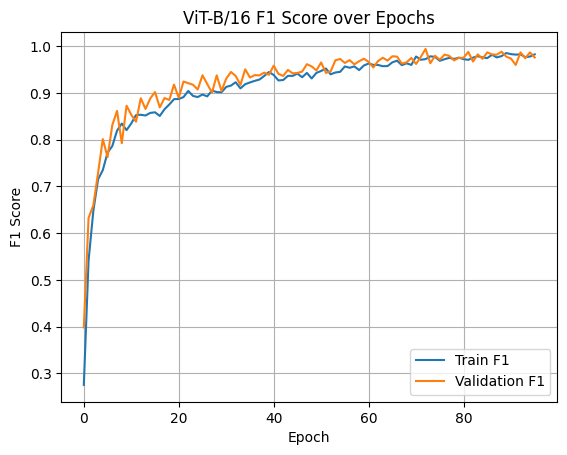

In [60]:
# CSV 파일 읽기
logs_df = pd.read_csv("/workspace/logs_baseline.csv")

# 데이터 확인
print(logs_df.tail())

# 성능 그래프 시각화
plt.plot(logs_df["epoch"], logs_df["train_f1"], label="Train F1")
plt.plot(logs_df["epoch"], logs_df["val_f1"], label="Validation F1")
plt.title("ViT-B/16 F1 Score over Epochs")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.show()


In [66]:
# 원본 디렉터리와 타겟 디렉터리 경로 설정
source_dir = "/workspace/test"
public_dir = "/workspace/test_public"
private_dir = "/workspace/test_private"

# 타겟 디렉터리 생성
os.makedirs(public_dir, exist_ok=True)
os.makedirs(private_dir, exist_ok=True)

# 파일 목록 불러오기
files = os.listdir(source_dir)

# 파일 무작위 셔플
random.shuffle(files)

# 파일 반반으로 나누기
mid_index = len(files) // 2
public_files = files[:mid_index]
private_files = files[mid_index:]

# 파일을 public_dir로 복사
for file_name in public_files:
    source_path = os.path.join(source_dir, file_name)
    target_path = os.path.join(public_dir, file_name)
    shutil.copy(source_path, target_path)

# 파일을 private_dir로 복사
for file_name in private_files:
    source_path = os.path.join(source_dir, file_name)
    target_path = os.path.join(private_dir, file_name)
    shutil.copy(source_path, target_path)

print(f"Files successfully split into '{public_dir}' and '{private_dir}'")
print(count_files_in_folder('/workspace/test_public'))

Files successfully split into '/workspace/test_public' and '/workspace/test_private'
1570


In [69]:
# 경로 설정
test_public_dir = "/workspace/test_public"
test_private_dir = "/workspace/test_private"
model_path = "/workspace/best_vit_base_patch16_224_best.pth"
output_csv_public = "/workspace/test_public_predictions.csv"
output_csv_private = "/workspace/test_private_predictions.csv"

# 이미지 전처리 파이프라인 설정
tst_transform = A.Compose([
                        ResizeImage(img_size=img_size),
                        A.Normalize(mean=mean, std=std),
                        ToTensorV2()
                        ])

# 모델 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=17)  # 모델 정의

# 저장된 체크포인트 로드
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint["model_state_dict"]  # 모델의 가중치만 추출
model.load_state_dict(state_dict)  # 모델에 가중치 로드
model = model.to(device)
model.eval()

/tmp/ipykernel_1731/1577115540.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [72]:
# 파일 리스트에서 추론 수행 함수
def predict_from_directory(directory, output_csv_path):
    predictions = []
    files = os.listdir(directory)

    for file_name in files:
        file_path = os.path.join(directory, file_name)

        # 이미지 로드 및 전처리
        try:
            image = Image.open(file_path).convert("RGB")
            image_np = np.array(image)  # PIL 이미지를 NumPy 배열로 변환
            
            # Albumentations 전처리 적용
            transformed = tst_transform(image=image_np)  # image를 명시적으로 전달
            image_tensor = transformed['image'].unsqueeze(0).to(device)  # Tensor로 변환
            
            # 추론
            with torch.no_grad():
                outputs = model(image_tensor)
                predicted_class = torch.argmax(outputs, dim=1).item()

            # 결과 저장
            predictions.append({
                "file_name": file_name,
                "predicted_class": predicted_class
            })
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

    # 결과를 CSV로 저장
    df = pd.DataFrame(predictions)
    df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")

In [73]:
# Public 디렉터리 추론
predict_from_directory(test_public_dir, output_csv_public)

Predictions saved to /workspace/test_public_predictions.csv


In [74]:
# Private 디렉터리 추론
predict_from_directory(test_private_dir, output_csv_private)

Predictions saved to /workspace/test_private_predictions.csv


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       0.98      1.00      0.99        46
           2       1.00      1.00      1.00       105
           3       0.65      0.59      0.62       111
           4       0.82      0.80      0.81       105
           5       1.00      1.00      1.00        99
           6       0.96      1.00      0.98        93
           7       0.53      0.47      0.49        90
           8       1.00      1.00      1.00       111
           9       1.00      1.00      1.00        98
          10       0.98      0.98      0.98       104
          11       1.00      0.94      0.97        95
          12       0.97      0.98      0.97        89
          13       0.99      0.99      0.99        74
          14       0.52      0.79      0.62        42
          15       1.00      1.00      1.00       107
          16       1.00      1.00      1.00       103

   

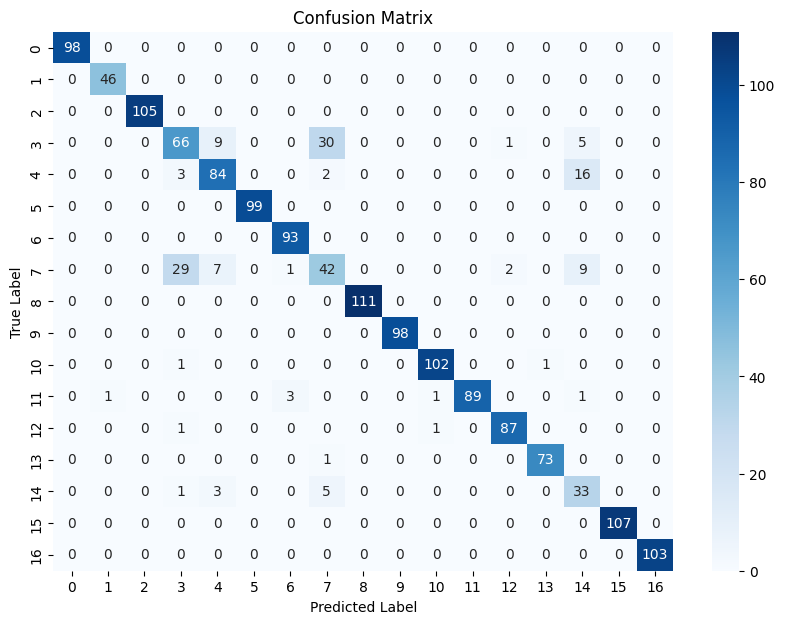

In [9]:
# 파일 경로 설정
predictions_file = "/workspace/test_public_predictions.csv"
ground_truth_file = "/workspace/test_public_private/test_public.csv"

# CSV 파일 읽기
predictions_df = pd.read_csv(predictions_file)
ground_truth_df = pd.read_csv(ground_truth_file)

# 두 데이터프레임 병합 (file_name 기준으로)
merged_df = predictions_df.merge(ground_truth_df[['file_name', 'target']], on='file_name', how='inner')

# 예측값과 실제값 추출
y_pred = merged_df['predicted_class']
y_true = merged_df['target']

# Classification Report 출력
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Accuracy와 Macro F1-score 계산
accuracy = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Confusion Matrix 생성
conf_matrix = confusion_matrix(y_true, y_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()